# **FitDSFCurves2**







**A python jiffy to fit DSF data with a modified Boltzmann equation to determine a value for Tm and slope.**

Antony W. Oliver, University of Sussex (2023)

For 'simple' use, please choose the '**Run all**' option, from the 'Runtime' drop-down menu.

---

In [ ]:
#@title Initialisation

# Run once initialisation (lmfit, seaborn)
%pip install lmfit
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.0 MB/s eta 0:00:00


The first column of the uploaded .csv file should contain temperature data.

The remaining columns should contain the melting data.

[one column per individual experimental repeat].

In [ ]:
#@title Upload .csv file

# Setup requirements
import io
import math
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
from scipy.optimize import curve_fit
from google.colab import files
from google.colab import output

def spacer ():
  print ("")
  print ("— — — — —")
  print ("")
  return

# Upload .csv file and eliminate NaN and column headers
uploaded = files.upload()

# Upload .csv file, drop headers and remove NaN values
filename = next(iter(uploaded))
raw_data = pd.read_csv(filename, header=None, skiprows=1, encoding='unicode_escape')
raw_data = raw_data.dropna(axis='rows')


Saving HKDprot_GCN2_edit.csv to HKDprot_GCN2_edit.csv


In [ ]:
#@title Options
print ()
normalise = float(input ("Enter 0 if data the already normalised (or to do nothing) or 1 to normalise the data: "))
print ()
fix_range = float(input ("Do you wish to fix the denatured intercept (No = 0, Yes = 1): "))

if fix_range == 1:
  bounds_lower = (-np.inf,-np.inf,-np.inf,0.98,20,-np.inf)
  bounds_upper = (np.inf,np.inf,np.inf,1.01,120,np.inf)
  print ()
  print ("denatured intercept has been fixed to a value of 1")

else:
  bounds_lower = (-np.inf,-np.inf,-np.inf,-np.inf,20,-np.inf)
  bounds_upper = (np.inf,np.inf,np.inf,np.inf,120,np.inf)


Enter 0 if data the already normalised (or to do nothing) or 1 to normalise the data: 1

Do you wish to fix the denatured intercept (No = 0, Yes = 1): 0



Please enter lowest temperature for fitting, enter 0 to use full input range 50

Please enter highest temperature for fitting, enter 0 to use full input range: 75

... fitting data and generating plots

Data in column 1 converged after 21 iterations.


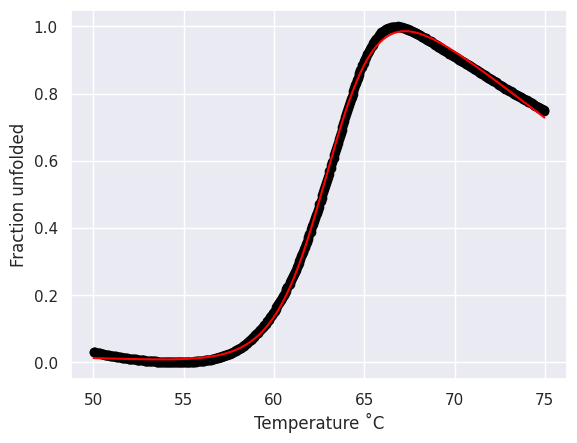

Fitted Values:

Tm: 63.152327363617985
Slope: 1.4609481186320832

— — — — —

Data Summary

Tm for column 1 : 63.15

Average Tm: 63.15
1 Standard Deviation:  0.0

— — — — —

Slope for column 1 : 1.46

Average Slope: 1.46
1 Standard Deviation:  0.0



In [ ]:
#@title Fit and Plot Data

print ()
lower_range = float(input ("Please enter lowest temperature for fitting, enter 0 to use full input range "))

print ()
upper_range = float(input ("Please enter highest temperature for fitting, enter 0 to use full input range: "))

print ()
# find number of columns
num_columns = len(raw_data.columns)

if lower_range == 0:
  data_lower = raw_data
else:
  data_lower = raw_data[raw_data[0] >= lower_range]

if upper_range == 0:
  data_upper = data_lower
else:
  data_upper = data_lower[data_lower[0] <= upper_range]

data = data_upper

print ("... fitting data and generating plots")
print ()

# Create x and y-data variables from uploaded .csv file (y_data1 for column 1, y_data2 for column2 etc)

x_data = data.iloc[:,0]

pd.options.mode.chained_assignment = None

for i in range(1, num_columns):
      min_val = data.iloc[:,i].min()
      max_val = data.iloc[:,i].max()
      if normalise == 1:
        data.iloc[:,i]= (data.iloc[:,i] - min_val) / (max_val - min_val)
        globals()[f"y_data{i}"] = data.iloc[:,i]
      else:
        globals()[f"y_data{i}"] = data.iloc[:,i]

# Equation for fitting data
def user_defined_equation_1(x, slope_native, intercept_native, slope_denatured, intercept_denatured, melting_temp, slope_midpoint):
  return ((slope_native * x + intercept_native) + (((slope_denatured * x + intercept_denatured)-(slope_native * x + intercept_native)/(1 + (np.exp((melting_temp - x) / slope_midpoint))))))

# Number of iterations
max_iterations = 2000

# Set initial guess
initial_guess = [0,0,0,1,35,2]

# Perform iterative fitting with Levenberg-Marquardt

for i in range (1, num_columns):

  input_y_data = globals()[f"y_data{i}"]

  for iteration in range(max_iterations):

    # Use curve_fit with the current initial guess and 'lm' method
    fit_params, covariance = curve_fit(user_defined_equation_1, x_data, input_y_data, p0=initial_guess, method='trf', bounds=(bounds_lower, bounds_upper))
    # Generate fitted y values using the fitted parameters
    y_fit = user_defined_equation_1(x_data, *fit_params)

    # Check for convergence (you can customize this condition based on your needs)
    if np.all(np.abs(np.array(initial_guess) - np.array(fit_params)) < 1e-6):
        print(f'Data in column {i} converged after {iteration + 1} iterations.')
        break

    # Update initial guess for the next iteration
    initial_guess = fit_params

  globals()[f"Tm_column{i}"] = fit_params[4]
  globals()[f"Slope_column{i}"] = fit_params[5]

  # Initialize plot
  sns.set_theme()
  fig, ax = plt.subplots()
  # Plot data
  ax.scatter(x_data, input_y_data, label='Data', color='black')
  plt.xlabel('Temperature ˚C')

  if normalise == 1:
    plt.ylabel('Fraction unfolded')
  else:
    plt.ylabel('Fluorescence (arbitary units)')
  ax.plot(x_data, y_fit, color='red')
  plt.show()

  # Print the final values for each parameter
  print("Fitted Values:")
  print ()
  print("Tm:",fit_params[4])
  print("Slope:",fit_params[5])

# Create Summary

spacer()
print ("Data Summary")
print ()

sum_tm = 0
tm_value = pd.Series((), dtype='float')

for i in range (1, num_columns):
  result_float = round(float(globals()[f"Tm_column{i}"]),2)
  print("Tm for column",i,":", result_float)
  sum_tm = sum_tm + result_float
  tm_value.loc[i] = result_float

mean = round(float((np.average(tm_value))),2)
standard = round(float((np.std(tm_value))),4)
print ()
print ("Average Tm:", mean)
print ("1 Standard Deviation: ", standard)

sum_slope = 0
slope_value = pd.Series((), dtype='float')

spacer()

for i in range (1, num_columns):
  result_float = round(float(globals()[f"Slope_column{i}"]),2)
  print("Slope for column",i,":", result_float)
  sum_slope = sum_slope + result_float
  slope_value.loc[i] = result_float

mean = round(float((np.average(slope_value))),2)
standard = round(float((np.std(slope_value))),4)
print ()
print ("Average Slope:", mean)
print ("1 Standard Deviation: ", standard)

print()


